In [1]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import clean_corpus_basic, clean_corpus_standford
from reader import read_files
from lstm_utils import get_tokenizer, get_best_tokens_dummy

from sklearn.utils import shuffle

from keras.layers import Dense, LSTM
from keras.models import Model, Sequential

import numpy as np
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lefunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [8]:
# -------------- Hiperparametros -----------------

vector_size = 8
each_q = 128
batch_size = 2000
epoch = 256
min_lenght, max_length = 4, 8
train_to_test = 0.8

In [21]:
# Leemos los archivos
corpus = clean_corpus_basic(read_files("../dataset/", ["negative", "positive"]))

# Filtramos por longitud
debug("[El corpus tiene " + str(len(corpus)) + " rows]")

#corpus["length"] = corpus["content"].map(lambda x: len(x.split(" ")))
#corpus = corpus[(corpus["length"] >= min_lenght) & (corpus["length"] <= max_length)]

debug("[Luego de filtrar el corpus tiene " + str(len(corpus)) + " rows]")

#Shuffleamos el corpus
corpus = shuffle(corpus)
corpus.reset_index(inplace=True, drop=True)



[Leyendo archivos en panda...]
[Archivos Leidos...]
[Usando cleaner basico]
[Limpiando el corpus...]
[Usando 8 threads ...]
[El corpus tiene 20000 rows]
[Luego de filtrar el corpus tiene 20000 rows]


In [22]:
# Seleccionamos los mejores tokens
best_tokens = get_best_tokens_dummy(corpus, each_q)
max_features = best_tokens.size

tokenizer = get_tokenizer(best_tokens, vector_size)

# Vectorizamos
debug("[Vectorizando corpus... ]")
corpus['vector'] = tokenizer(corpus['content'])

corpus.head()

[Vectorizando corpus... ]


,content,sentiment,raw,rate,vector
0,EXCELENT EXCELENT HERM ZAPATILL CUAL FOT RECOMEND,"[1, 0]",Excelente Excelente!!! hermosas zapatillas tal...,positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,MAL DEMASI CAR REALMENT ESPEJ BASIC DEMASI FRAGIL,"[0, 1]",Malo Demasiado caro para lo que realmente es e...,negative,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,RECLAM HOL PROB VENT FICTICI ANDUV BIEN AHOR H...,"[1, 0]",producto y reclamo hola lo probé con una venta...,positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,PRIMAVER 10 TOD PERFECT MUCH GRACI,"[1, 0]","De primavera De 10, todo perfecto. Muchas gracias",positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,EXCELENT TOD PERFECT PED LLEG TIEMP FORM,"[1, 0]","Excelente Todo perfecto , lo que pedí me llegó...",positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [23]:
# Dividimos el corpus

x_total = np.stack(corpus["vector"].values)
y_total = np.stack(corpus['sentiment'].values)

x_train, x_test = np.split(x_total, [int(train_to_test * len(x_total))])
y_train, y_test = np.split(y_total, [int(train_to_test * len(x_total))])

log("[Son " + str(len(x_train)) + " train sequences]")
log("[Son " + str(len(x_test)) + " test sequences]")



[Son 16000 train sequences]
[Son 4000 test sequences]


In [24]:
# Calculamos la cantidad de neuronas con las que vamos a procesar

lstm_neurons = [int((2/3) * (2 + max_features))]

for a in range(2, 10 + 1):
    dem = a * (2 + max_features )
    lstm_neurons.append(int(len(x_train) / dem))

lstm_neurons = list( dict.fromkeys(lstm_neurons) )

log("[Las neuronas van a ser: " + str(lstm_neurons) + "]")

[Las neuronas van a ser: [125, 42, 28, 21, 17, 14, 12, 10, 9, 8]]


In [25]:
#Entrenamos modelo y testeamos

lstm_results = []
for neurons in lstm_neurons: 
    log("-----------------------")
    log("[Usando " + str(neurons) + " neuronas]")

    #Buildemos modelo
    log("[Buildeando modelo... ]")

    model = Sequential()
    model.add(LSTM(neurons, dropout=0.2, input_shape=(vector_size, max_features)))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    log("[Modelo buildeado]")

    # Fitteamos
    log("[Fiteando modelo... ]")
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epoch,  
              validation_data=(x_test, y_test),
                verbose=0)
    
    
    #Testeamos
    log("[Testeando modelo... ]")
    score, acc = model.evaluate(x_test, y_test,
                                batch_size=batch_size,
                               verbose=0)
    
    log("[   Score: " + str(score))
    log("[   Accuaracy: " + str(acc))
    
    lstm_results.append((neurons, score, acc, history))

-----------------------
[Usando 125 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.22323814779520035
[   Accuaracy: 0.9380000233650208
-----------------------
[Usando 42 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.1872880458831787
[   Accuaracy: 0.9412500262260437
-----------------------
[Usando 28 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.17897886782884598
[   Accuaracy: 0.9409999847412109
-----------------------
[Usando 21 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.18138782680034637
[   Accuaracy: 0.9390000104904175
-----------------------
[Usando 17 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.17811087518930435
[   Accuaracy: 0.9442499876022339
----------

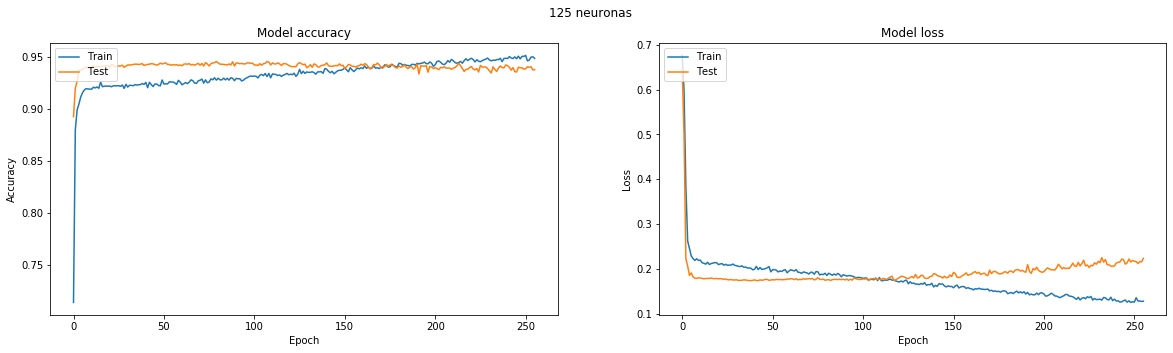

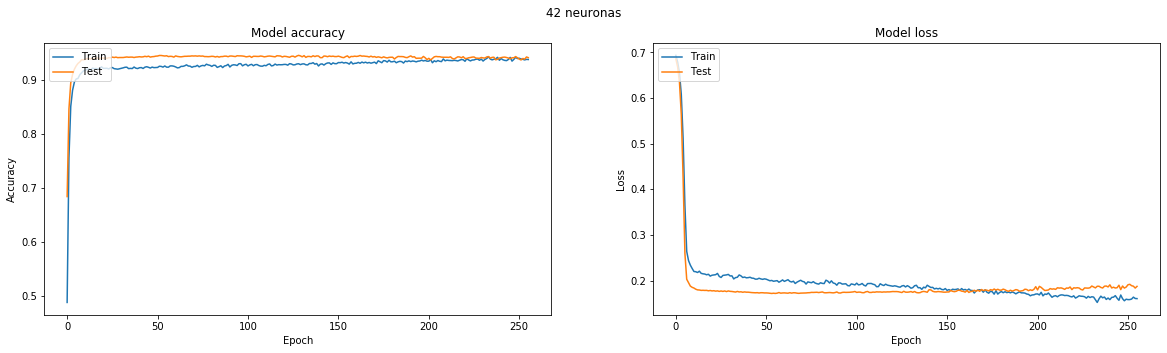

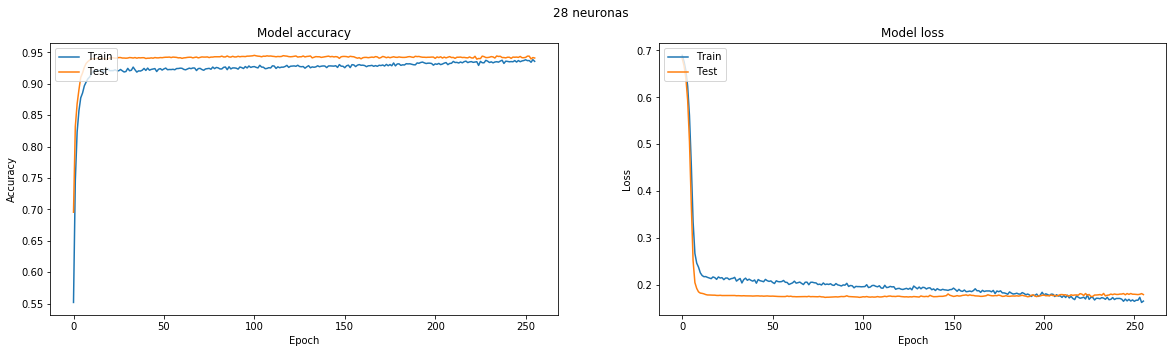

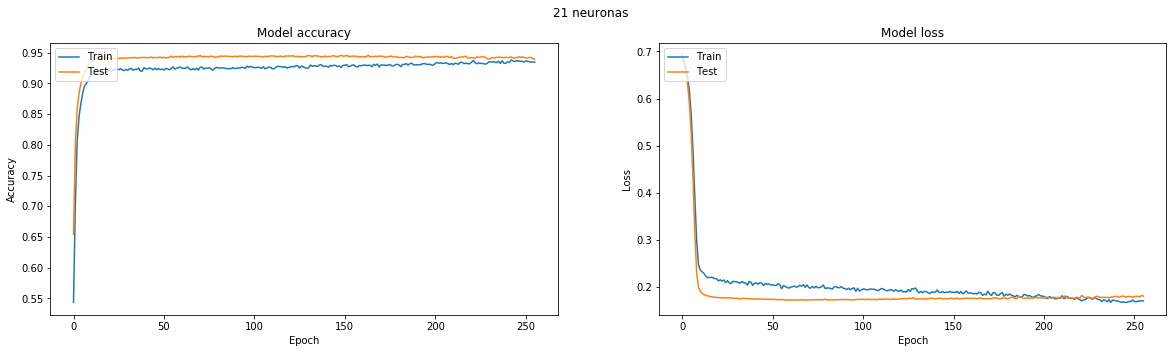

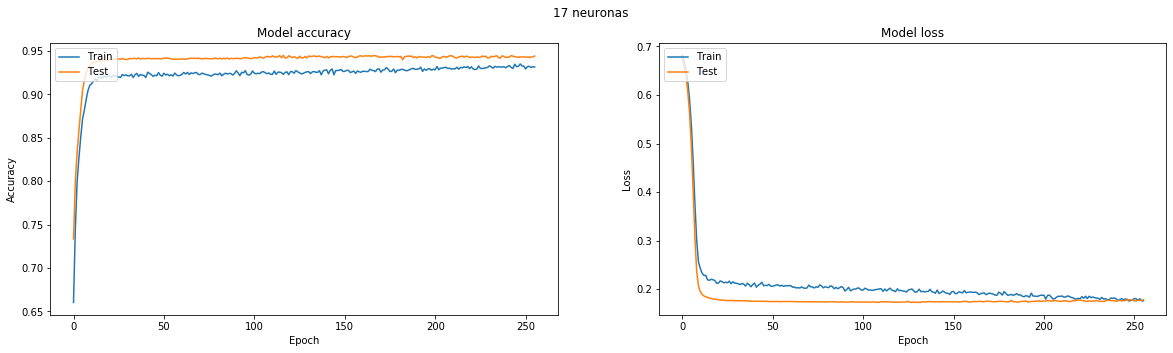

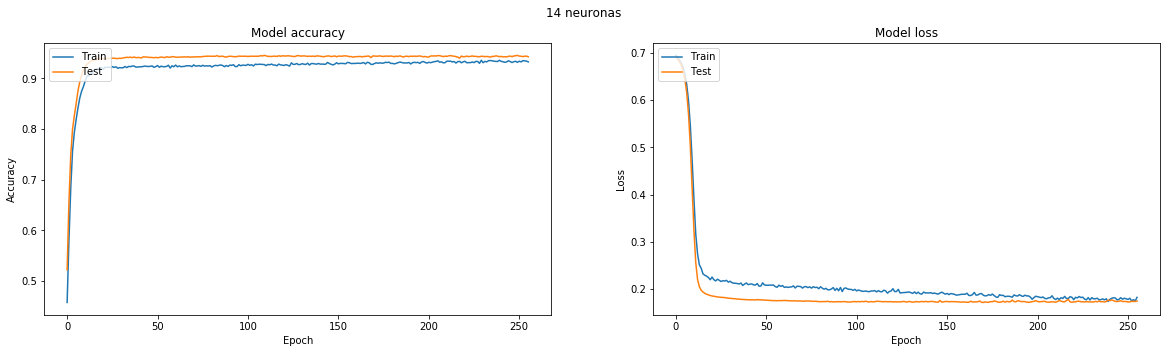

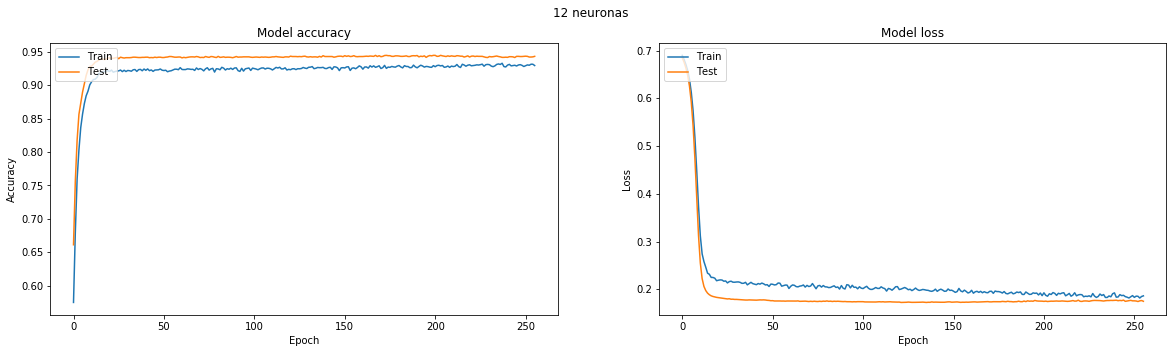

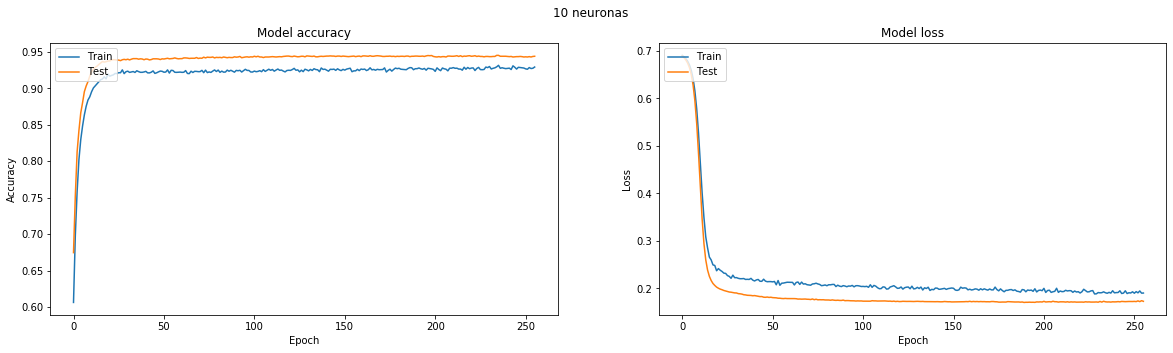

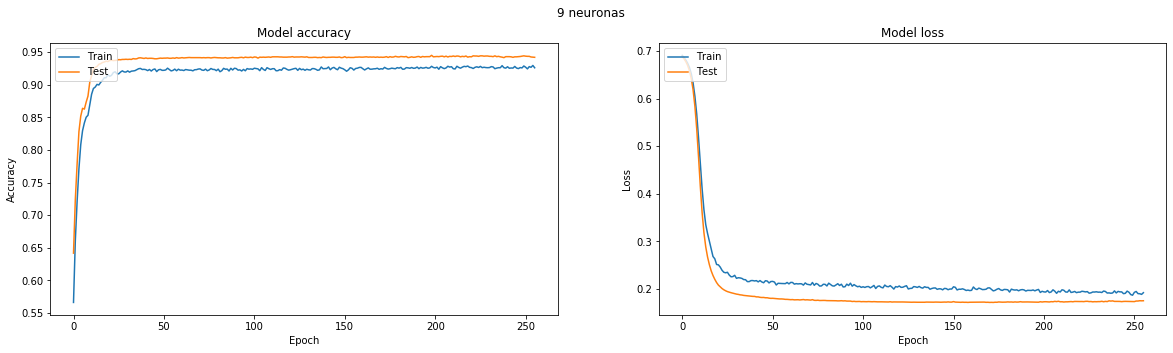

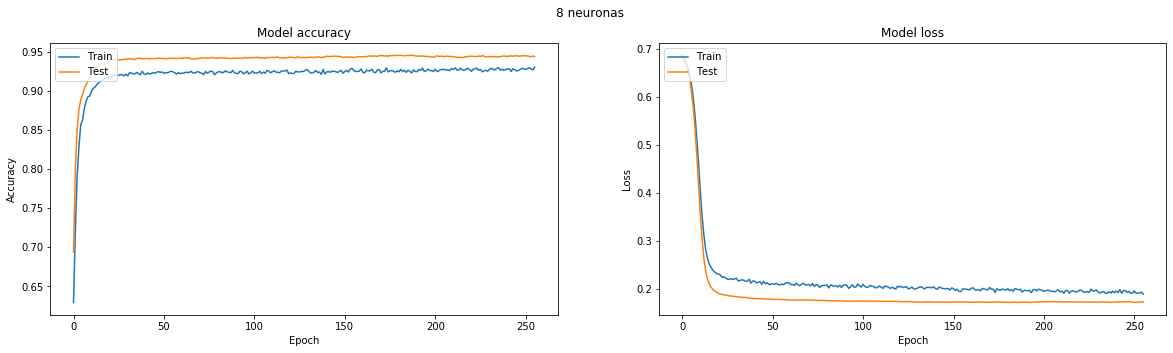

In [26]:
graph_prefix = "no_restricted_dummy_"

for (neurons, score, acc, history) in lstm_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(str(neurons) + ' neuronas')
    
    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label= "Train")
    ax1.plot(history.history['val_accuracy'], label= "Test")
    
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc="upper left")
    

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label= "Train")
    ax2.plot(history.history['val_loss'], label= "Test")
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc="upper left")
    
    fig.savefig('./graphs/' + graph_prefix + str(neurons) + '.png')
    
